In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd
import scipy.ndimage

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [3]:
import sys
sys.path.append('..')

from utils.attributes_augmentations import Augmentation
from utils.attributes_dataset import ISIC_Dataset
from utils.cyst_enhanced import Pores
%load_ext autoreload
%autoreload 2

In [4]:
import pickle 
amounts = pickle.load(open('../data/patches_amounts.pkl', 'rb'))
attributes_areas = pickle.load(open('../data/attribute_areas.pkl', 'rb'))

train_dataset = ISIC_Dataset('../data/cropped_full/', seed=None, 
                             appearence_mean=[0., 1., 0., 0., 0., 0.],
                             augmentator=Augmentation,
                             aug_params={'side': 576},
                             is_test=True,
#                              amounts=amounts,
                             part=0, partsamount=1, exclude=False)

100%|██████████| 2594/2594 [02:53<00:00, 14.94it/s]


In [5]:
def crop(image, mask):
    coords = np.array(np.where(mask))
    x_min, x_max = coords[0].min(), coords[0].max()
    y_min, y_max = coords[1].min(), coords[1].max()
    return (
        image[x_min: x_max, y_min: y_max],
        mask[x_min: x_max, y_min: y_max],
        (x_min, x_max),
        (y_min, y_max)
    )

In [6]:
def normalize_dots(dots, labeled, colours):
    """
    Threshold enhanced images from outliers through `self.DNG_level` * sigma,
    sigma is computed from renormalized Dots Enhanced destribution.
    """
    dots_mean = list()
    dots_std = list()
    new_dot = np.zeros(dots.shape)
    for colour in range(colours):
        area = (labeled == (colour + 1)) & (dots > 0)
        
        new_dot[area] = np.log(dots[area])

        lower_bound = np.percentile(new_dot[area], 1)
        upper_bound = np.percentile(new_dot[area], 99)

        dots_mean.append(np.median(new_dot[area]))
        dots_std.append(new_dot[(new_dot > lower_bound) 
                                & (new_dot < upper_bound)].std())

        new_dot[area] = (new_dot[area] - dots_mean[-1]) / dots_std[-1]
    return new_dot

In [10]:
root_dir = '../data/ISIC2018_Task1-2_Training_Input'
out_path = '../data/Task2Cysts/ISIC_{}'

template = {
    'image': 'ISIC_{}.jpg',
    'attribute': 'ISIC_{}_attribute_milia_like_cyst.png',
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


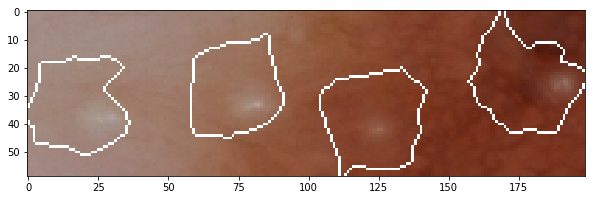

In [54]:
for i, key in tqdm(enumerate(train_dataset.appearence_keys[1])):
    path = train_dataset.paths[key]['attributes'][1]
    name = os.path.basename(path).split('_')[1]
    image = cv2.imread(
        os.path.join(root_dir, template['image']).format(name))[..., ::-1] / 255.
    mask_orig = cv2.imread(
        os.path.join(root_dir, template['attribute'].format(name)), 0) > 0
    image, mask, xs, ys = crop(image, mask_orig)
    mask_ = (
        np.logical_not(mask) 
        & scipy.ndimage.binary_dilation(mask, iterations=1)
    )

    labeled, colours = scipy.ndimage.label(mask)
    larea = list()
    for colour in range(colours):
        larea.append(np.sqrt((labeled == (colour + 1)).sum()))
    larea = np.array(larea)

    im = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    im = im.astype(np.float)
    prepared = im[..., 1] - scipy.ndimage.gaussian_filter(
        im[..., 1], np.mean(larea) / 2
    )
    rad = larea / (2 * np.sqrt(np.pi))
    pores = Pores(rad.min(), rad.max(), detect_bright_motes=False, normalize=True)
    cysts = pores(np.array([prepared]), masks=[mask])
#     new_dots = normalize_dots(pores.dots[0], labeled, colours)
    new_dots = pores.dots[0]
    new_dots[new_dots < 0] = 0
    dots = (new_dots * scipy.ndimage.binary_erosion(mask) * (new_dots > 0)) > 2
    dots = scipy.ndimage.binary_opening(dots, iterations=2)

    if (i) % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        dots_ = (
            np.logical_not(dots)
            & scipy.ndimage.binary_dilation(dots, iterations=1)
        )
        image[..., 0] += dots_ / 2.
        plt.imshow(image + np.expand_dims(mask_, -1))
        plt.show()

    new_mask = np.zeros_like(mask_orig)
    new_mask[xs[0]: xs[1], ys[0]: ys[1]] = dots
    np.save(out_path.format(name), new_mask.astype(np.bool_))
    if i == 20:
        break

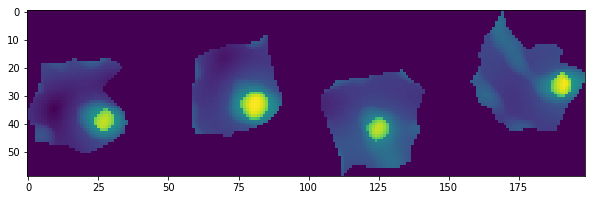

In [69]:
plt.figure(figsize=(10, 10))
im = image.copy()
# im[mask] += np.array([0, .2, 0])
plt.imshow(pores.DNG[0] + (pores.dots[0] * dots) / 10)
plt.show()

# Loss visualisation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [23]:
import numpy as np
import scipy.signal
import shutil
import pickle
# import seaborn as sbn

import itertools
from sklearn.metrics import confusion_matrix

# template = 'attributes_checkpoints/fpn_dpn92/fold_{}_checkpoint.epoch_loss'
template = 'classification_checkpoints/resnext101_64/fold_{}_checkpoint.epoch_{}_fpn'
# template = 'snapshot_emb/fold_{}_checkpoint.epoch_{}_fpn'
out_dir = 'classification_checkpoints/best_resnext101_64/fold_{}_checkpoint.epoch_{}'

In [24]:
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          axes=None, fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if axes is None:
        axes = plt
        fig = plt
    cax = axes.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    axes.set_title(title)
    fig.colorbar(cax)
    tick_marks = np.arange(len(classes))
    axes.set_xticks(tick_marks)
    axes.set_xticklabels(classes)
    axes.set_yticks(tick_marks)
    axes.set_yticklabels(classes)
    axes.tick_params(axis='x', rotation=30)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')


In [26]:
losses = [pickle.load(open(template.format(i, 'loss'), 'rb')) for i in range(4)]

In [27]:
accuraacy = list()
cnfs = list()

for loss in losses:
    cnf_matrix = [confusion_matrix(t, p) 
                        for t, p in zip(loss['val_trues'], loss['val_pred'])]
    accs = np.array([cnf.diagonal() / cnf.sum(1) for cnf in cnf_matrix])
    accuraacy.append(np.mean(accs, axis=1))
    cnfs.append(cnf_matrix)

In [28]:
accuraacy[0]

array([0.63273606, 0.74905192, 0.76799644, 0.83731664, 0.80369935,
       0.8264727 , 0.82348178, 0.75806033, 0.78653903, 0.79802281,
       0.82486583, 0.77687421, 0.75624644])

In [22]:
accuraacy

[array([0.79448104, 0.82305858])]

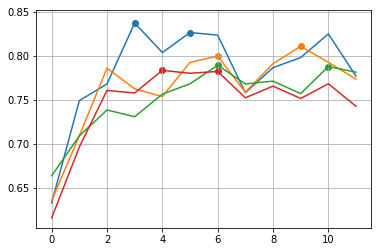

In [14]:
idxs = list()
for i, acc in enumerate(accuraacy):
    sup_idxs = scipy.signal.argrelextrema(acc, np.greater)[0]
    ks = acc[sup_idxs].argsort()[-2:][::-1]
    idxs.append(sup_idxs[ks])
    plt.plot(acc[:-1], 'C{}'.format(i))
    plt.scatter(idxs[-1], acc[idxs[-1]], c='C{}'.format(i))
plt.grid()

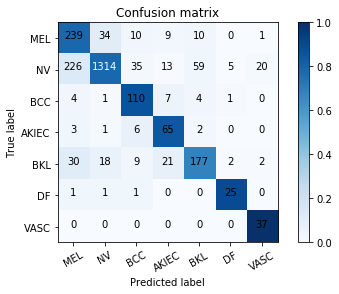

In [16]:
fig = plt.figure()
axes = fig.add_subplot(111)
CLASSES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
plot_confusion_matrix(cnfs[0][idxs[0][0]], classes=CLASSES, fig=fig, axes=axes)

In [6]:
for fold, idx in enumerate(idxs):
    for epoch_i in idx:
        shutil.copy(template.format(fold, epoch_i), out_dir.format(fold, epoch_i))

In [ ]:
# elr = ExpLR(opt, src_lr=1e-3, dst_lr=1e-4, step_size=400)

# plt.figure(figsize=(10, 10))
# plt.plot([elr.batch_step() for i in range(400)])
# plt.ylabel('learning rate')
# plt.xlabel('Iteration')
# plt.grid()
# plt.legend()

In [ ]:
a

In [23]:
lattrs = np.array([
    [l['full_attr'] for l in lfold['train_iou']] 
    for lfold in losses
])

In [24]:
attributes = [
    'globules',            # 255, 0, 0
    'milia_like cyst',     # 255, 255, 0
    'negative network',    # 255, 255, 255
    'pigment network',     # 255, 0, 255
    'streaks',             # 0, 255, 0
    'segmentation'         # 0, 0, 255
]

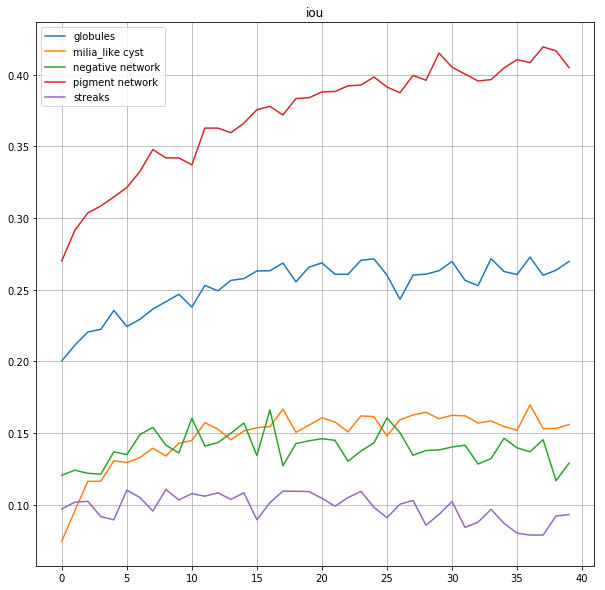

In [12]:
# sbn.set_style('darkgrid')
fig = plt.figure(figsize=(10, 10))
for i, ls in enumerate(lattrs.mean(0).T):
    plt.plot(ls[10:], label=attributes[i])

plt.title('iou')
plt.legend()
plt.grid()

In [ ]:
'classification_checkpoints/dpn92/fold_0_checkpoint.epoch_0_fpnfold_0_checkpoint.epoch_0_fpn'

In [2]:
from glob import glob
import os

In [5]:
paths = glob('../data/ISIC2018_Task1-2_Training_Input/*.jpg')
ids12 = [os.path.basename(path) for path in paths]
paths = glob('../data/ISIC2018_Task3_Training_Input/*.jpg')
ids3 = [os.path.basename(path) for path in paths]

set()

In [12]:
ids12[-1], ids3[0]

('ISIC_0011144.jpg', 'ISIC_0026535.jpg')

In [ ]:
'classification_checkpoints/resnext101_64/fold_2_checkpoint.epoch_7_fpn'